In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# %cd /content/drive/MyDrive/dataset/klasifikasi_squat/model4

/content/drive/MyDrive/dataset/klasifikasi_squat/model4


In [ ]:
# ls

examples/                     landmark_squat_train_data.csv  squat_labels.txt  weights.best.hdf5
landmark_squat_test_data.csv  movenet_thunder.tflite         squat.tflite


In [ ]:
!pip install -q opencv-python

In [ ]:
import csv
import cv2
import itertools
import numpy as np
import pandas as pd
import os
import sys
import tempfile
import tqdm

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
# Download model from TF Hub and check out inference code from GitHub
!wget -q -O movenet_thunder.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/float16/4?lite-format=tflite
!git clone https://github.com/tensorflow/examples.git
pose_sample_rpi_path = os.path.join(os.getcwd(), 'examples/lite/examples/pose_estimation/raspberry_pi')
sys.path.append(pose_sample_rpi_path)

# Load MoveNet Thunder model
import utils
from data import BodyPart
from ml import Movenet
movenet = Movenet('movenet_thunder')

# Define function to run pose estimation using MoveNet Thunder.
# You'll apply MoveNet's cropping algorithm and run inference multiple times on
# the input image to improve pose estimation accuracy.
def detect(input_tensor, inference_count=3):
  image_height, image_width, channel = input_tensor.shape

  # Detect pose using the full input image
  movenet.detect(input_tensor.numpy(), reset_crop_region=True)

  # Repeatedly using previous detection result to identify the region of
  # interest and only croping that region to improve detection accuracy
  for _ in range(inference_count - 1):
    person = movenet.detect(input_tensor.numpy(),
                            reset_crop_region=False)

  return person

fatal: destination path 'examples' already exists and is not an empty directory.


In [ ]:
# def draw_prediction_on_image(
#     image, person, crop_region=None, close_figure=True,
#     keep_input_size=False):
#   # Draw the detection result on top of the image.
#   image_np = utils.visualize(image, [person])

#   # Plot the image with detection results.
#   height, width, channel = image.shape
#   aspect_ratio = float(width) / height
#   fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
#   im = ax.imshow(image_np)

#   if close_figure:
#     plt.close(fig)

#   if not keep_input_size:
#     image_np = utils.keep_aspect_ratio_resizer(image_np, (512, 512))

#   return image_np

In [ ]:
# class MoveNetPreprocessor(object):
#   def __init__(self,
#                images_in_folder,
#                images_out_folder,
#                csvs_out_path):

#     self._images_in_folder = images_in_folder
#     self._images_out_folder = images_out_folder
#     self._csvs_out_path = csvs_out_path
#     self._messages = []

#     # Create a temp dir to store the pose CSVs per class
#     self._csvs_out_folder_per_class = tempfile.mkdtemp()

#     # Get list of pose classes and print image statistics
#     self._pose_class_names = sorted(
#         [n for n in os.listdir(self._images_in_folder) if not n.startswith('.')]
#         )

#   def process(self, per_pose_class_limit=None, detection_threshold=0.1):
#     # Loop through the classes and preprocess its images
#     for pose_class_name in self._pose_class_names:
#       print('Preprocessing', pose_class_name, file=sys.stderr)

#       # Paths for the pose class.
#       images_in_folder = os.path.join(self._images_in_folder, pose_class_name)
#       images_out_folder = os.path.join(self._images_out_folder, pose_class_name)
#       csv_out_path = os.path.join(self._csvs_out_folder_per_class,
#                                   pose_class_name + '.csv')
#       if not os.path.exists(images_out_folder):
#         os.makedirs(images_out_folder)

#       # Detect landmarks in each image and write it to a CSV file
#       with open(csv_out_path, 'w') as csv_out_file:
#         csv_out_writer = csv.writer(csv_out_file,
#                                     delimiter=',',
#                                     quoting=csv.QUOTE_MINIMAL)
#         # Get list of images
#         image_names = sorted(
#             [n for n in os.listdir(images_in_folder) if not n.startswith('.')])
#         if per_pose_class_limit is not None:
#           image_names = image_names[:per_pose_class_limit]

#         valid_image_count = 0

#         # Detect pose landmarks from each image
#         for image_name in tqdm.tqdm(image_names):
#           image_path = os.path.join(images_in_folder, image_name)

#           try:
#             image = tf.io.read_file(image_path)
#             image = tf.io.decode_jpeg(image)
#           except:
#             self._messages.append('Skipped ' + image_path + '. Invalid image.')
#             continue
#           else:
#             image = tf.io.read_file(image_path)
#             image = tf.io.decode_jpeg(image)
#             image_height, image_width, channel = image.shape

#           # Skip images that isn't RGB because Movenet requires RGB images
#           if channel != 3:
#             self._messages.append('Skipped ' + image_path +
#                                   '. Image isn\'t in RGB format.')
#             continue
#           person = detect(image)

#           # Save landmarks if all landmarks were detected
#           min_landmark_score = min(
#               [keypoint.score for keypoint in person.keypoints])
#           should_keep_image = min_landmark_score >= detection_threshold
#           if not should_keep_image:
#             self._messages.append('Skipped ' + image_path +
#                                   '. No pose was confidentlly detected.')
#             continue

#           valid_image_count += 1

#           # Draw the prediction result on top of the image for debugging later
#           output_overlay = draw_prediction_on_image(
#               image.numpy().astype(np.uint8), person,
#               close_figure=True, keep_input_size=True)

#           # Write detection result into an image file
#           output_frame = cv2.cvtColor(output_overlay, cv2.COLOR_RGB2BGR)
#           cv2.imwrite(os.path.join(images_out_folder, image_name), output_frame)

#           # Get landmarks and scale it to the same size as the input image
#           pose_landmarks = np.array(
#               [[keypoint.coordinate.x, keypoint.coordinate.y, keypoint.score]
#                 for keypoint in person.keypoints],
#               dtype=np.float32)

#           # Write the landmark coordinates to its per-class CSV file
#           coordinates = pose_landmarks.flatten().astype(str).tolist()
#           csv_out_writer.writerow([image_name] + coordinates)

#         if not valid_image_count:
#           raise RuntimeError(
#               'No valid images found for the "{}" class.'
#               .format(pose_class_name))

#     # Print the error message collected during preprocessing.
#     print('\n'.join(self._messages))

#     # Combine all per-class CSVs into a single output file
#     all_landmarks_df = self._all_landmarks_as_dataframe()
#     all_landmarks_df.to_csv(self._csvs_out_path, index=False)

#   def class_names(self):
#     """List of classes found in the training dataset."""
#     return self._pose_class_names

#   def _all_landmarks_as_dataframe(self):
#     """Merge all per-class CSVs into a single dataframe."""
#     total_df = None
#     for class_index, class_name in enumerate(self._pose_class_names):
#       csv_out_path = os.path.join(self._csvs_out_folder_per_class,
#                                   class_name + '.csv')
#       per_class_df = pd.read_csv(csv_out_path, header=None)

#       # Add the labels
#       per_class_df['class_no'] = [class_index]*len(per_class_df)
#       per_class_df['class_name'] = [class_name]*len(per_class_df)

#       # Append the folder name to the filename column (first column)
#       per_class_df[per_class_df.columns[0]] = (os.path.join(class_name, '')
#         + per_class_df[per_class_df.columns[0]].astype(str))

#       if total_df is None:
#         # For the first class, assign its data to the total dataframe
#         total_df = per_class_df
#       else:
#         # Concatenate each class's data into the total dataframe
#         total_df = pd.concat([total_df, per_class_df], axis=0)

#     list_name = [[bodypart.name + '_x', bodypart.name + '_y',
#                   bodypart.name + '_score'] for bodypart in BodyPart]
#     header_name = []
#     for columns_name in list_name:
#       header_name += columns_name
#     header_name = ['file_name'] + header_name
#     header_map = {total_df.columns[i]: header_name[i]
#                   for i in range(len(header_name))}

#     total_df.rename(header_map, axis=1, inplace=True)

#     return total_df

In [ ]:
# class MovenetLayer(tf.keras.layers.Layer):
#     def __init__(self, model_path, **kwargs):
#         super(MovenetLayer, self).__init__(**kwargs)
#         self.model_path = model_path
#         self.interpreter = tf.lite.Interpreter(model_path=self.model_path)
#         self.interpreter.allocate_tensors()
#         self.input_details = self.interpreter.get_input_details()
#         self.output_details = self.interpreter.get_output_details()

#     def call(self, inputs):
#         # Resize and normalize inputs
#         resized_inputs = tf.image.resize(inputs, (256, 256))
#         input_tensor = tf.cast(resized_inputs, dtype=tf.uint8)  # Convert to UINT8
#         input_tensor = (tf.cast(input_tensor, dtype=tf.float32) - 127.5) / 127.5  # Normalize to [-1, 1]
#         input_tensor = tf.expand_dims(input_tensor, axis=0)  # Add batch dimension

#         # Convert to numpy array within the tf.py_function
#         keypoints = tf.py_function(self.get_keypoints, [input_tensor], tf.float32)
#         keypoints.set_shape([1, 17, 3])  # Set the shape explicitly to [batch_size, num_keypoints, 3]
#         return keypoints

#     @tf.function
#     def get_keypoints(self, input_tensor):
#         input_tensor_uint8 = np.uint8(input_tensor_numpy)  # Convert to UINT8
#         input_tensor = tf.cast(tf.expand_dims(image, axis=0), dtype=tf.uint8)

#         # Set tensor input for interpreter (expecting UINT8)
#         self.interpreter.set_tensor(self.input_details[0]['index'], input_tensor_uint8)
#         self.interpreter.invoke()

#         # Get output keypoints from interpreter
#         keypoints_with_scores = self.interpreter.get_tensor(self.output_details[0]['index'])
#         return keypoints_with_scores  # Return keypoints with scores


#Load CSVs preprocessed ke TRAIN dan TEST dataset.

In [ ]:
csvs_out_test_path = 'landmark_squat_test_data.csv'
csvs_out_train_path = 'landmark_squat_train_data.csv'


def load_pose_landmarks(csv_path):
  # Load the CSV file
  dataframe = pd.read_csv(csv_path)
  df_to_process = dataframe.copy()

  # Drop the file_name columns as you don't need it during training.
  df_to_process.drop(columns=['file_name'], inplace=True)

  # Extract the list of class names
  classes = df_to_process.pop('class_name').unique()

  # Extract the labels
  y = df_to_process.pop('class_no')

  # Convert the input features and labels into the correct format for training.
  X = df_to_process.astype('float64')

  return X, y, classes, dataframe

In [ ]:
# csvs_out_test_path = 'landmark_squat_test_data.csv'
# csvs_out_train_path = 'landmark_squat_train_data.csv'


# def load_pose_landmarks(csv_path):
#   # Load the CSV file
#   dataframe = pd.read_csv(csv_path)
#   df_to_process = dataframe.copy()

#   # Drop the file_name columns as you don't need it during training.
#   df_to_process.drop(columns=['file_name'], inplace=True)

#   # Extract the list of class names
#   classes = df_to_process.pop('class_name').unique()

#   # Extract the labels
#   y = df_to_process.pop('class_no')

#   # Convert the input features and labels into the correct format for training.
#   X = df_to_process.astype('float64')
#   y = keras.utils.to_categorical(y)

#   return X, y, classes, dataframe

In [ ]:
# Load the train data
X, y, class_names, _ = load_pose_landmarks(csvs_out_train_path)

# Split training data (X, y) into (X_train, y_train) and (X_val, y_val)
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.15)

In [ ]:
# Load the test data
X_test, y_test, _, df_test = load_pose_landmarks(csvs_out_test_path)

###Define functions to convert the pose landmarks to a pose embedding (a.k.a. feature vector) for pose classification

In [ ]:
def get_center_point(landmarks, left_bodypart, right_bodypart):
  left = tf.gather(landmarks, left_bodypart.value, axis=1)
  right = tf.gather(landmarks, right_bodypart.value, axis=1)
  center = left * 0.5 + right * 0.5
  return center


def get_pose_size(landmarks, torso_size_multiplier=2.5):
  # Hips center
  hips_center = get_center_point(landmarks, BodyPart.LEFT_HIP,
                                 BodyPart.RIGHT_HIP)

  # Shoulders center
  shoulders_center = get_center_point(landmarks, BodyPart.LEFT_SHOULDER,
                                      BodyPart.RIGHT_SHOULDER)

  # Torso size as the minimum body size
  torso_size = tf.linalg.norm(shoulders_center - hips_center)

  # Pose center
  pose_center_new = get_center_point(landmarks, BodyPart.LEFT_HIP,
                                     BodyPart.RIGHT_HIP)
  pose_center_new = tf.expand_dims(pose_center_new, axis=1)
  # Broadcast the pose center to the same size as the landmark vector to
  # perform substraction
  pose_center_new = tf.broadcast_to(pose_center_new,
                                    [tf.size(landmarks) // (17*2), 17, 2])

  # Dist to pose center
  d = tf.gather(landmarks - pose_center_new, 0, axis=0,
                name="dist_to_pose_center")
  # Max dist to pose center
  max_dist = tf.reduce_max(tf.linalg.norm(d, axis=0))

  # Normalize scale
  pose_size = tf.maximum(torso_size * torso_size_multiplier, max_dist)

  return pose_size


def normalize_pose_landmarks(landmarks):
  # Move landmarks so that the pose center becomes (0,0)
  pose_center = get_center_point(landmarks, BodyPart.LEFT_HIP,
                                 BodyPart.RIGHT_HIP)
  pose_center = tf.expand_dims(pose_center, axis=1)
  # Broadcast the pose center to the same size as the landmark vector to perform
  # substraction
  pose_center = tf.broadcast_to(pose_center,
                                [tf.size(landmarks) // (17*2), 17, 2])
  landmarks = landmarks - pose_center

  # Scale the landmarks to a constant pose size
  pose_size = get_pose_size(landmarks)
  landmarks /= pose_size

  return landmarks


def landmarks_to_embedding(landmarks_and_scores):
  # Reshape the flat input into a matrix with shape=(17, 3)
  reshaped_inputs = keras.layers.Reshape((17, 3))(landmarks_and_scores)

  # Normalize landmarks 2D
  landmarks = normalize_pose_landmarks(reshaped_inputs[:, :, :2])

  # Flatten the normalized landmark coordinates into a vector
  embedding = keras.layers.Flatten()(landmarks)

  return embedding

# Define the model

In [ ]:
# Define the model
inputs = tf.keras.Input(shape=(51))
embedding = landmarks_to_embedding(inputs)

layer = keras.layers.Dense(128, activation=tf.nn.relu6)(embedding)
layer = keras.layers.Dropout(0.5)(layer)
layer = keras.layers.Dense(64, activation=tf.nn.relu6)(layer)
layer = keras.layers.Dropout(0.5)(layer)
layer = keras.layers.Dense(32, activation=tf.nn.relu6)(layer)
layer = keras.layers.Dropout(0.5)(layer)
outputs = keras.layers.Dense(1, activation="sigmoid")(layer)

model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 51)]                 0         []                            
                                                                                                  
 reshape (Reshape)           (None, 17, 3)                0         ['input_1[0][0]']             
                                                                                                  
 tf.__operators__.getitem (  (None, 17, 2)                0         ['reshape[0][0]']             
 SlicingOpLambda)                                                                                 
                                                                                                  
 tf.compat.v1.gather (TFOpL  (None, 2)                    0         ['tf.__operators__.getitem

In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Add a checkpoint callback to store the checkpoint that has the highest
# validation accuracy.
checkpoint_path = "weights.best.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
earlystopping = keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                              patience=10)

# Start training
history = model.fit(X_train, y_train,
                    epochs=200,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint, earlystopping])

Epoch 1/200
19/24 [======================>.......] - ETA: 0s - loss: 0.6881 - accuracy: 0.5477
Epoch 1: val_accuracy improved from -inf to 0.91603, saving model to weights.best.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 4s 53ms/step - loss: 0.6861 - accuracy: 0.5575 - val_loss: 0.6617 - val_accuracy: 0.9160
Epoch 2/200
12/24 [==============>...............] - ETA: 0s - loss: 0.6575 - accuracy: 0.7500
Epoch 2: val_accuracy improved from 0.91603 to 0.95420, saving model to weights.best.hdf5
24/24 [==============================] - 0s 9ms/step - loss: 0.6395 - accuracy: 0.7848 - val_loss: 0.5711 - val_accuracy: 0.9542
Epoch 3/200
16/24 [===================>..........] - ETA: 0s - loss: 0.5629 - accuracy: 0.8574
Epoch 3: val_accuracy improved from 0.95420 to 0.99237, saving model to weights.best.hdf5
24/24 [==============================] - 0s 8ms/step - loss: 0.5437 - accuracy: 0.8579 - val_loss: 0.3901 - val_accuracy: 0.9924
Epoch 4/200
20/24 [========================>.....] - ETA: 0s - loss: 0.3813 - accuracy: 0.9375
Epoch 4: val_accuracy did not improve from 0.99237
24/24 [==============================] - 0s 5ms/step - loss: 0.3703 - accuracy: 0.9432 - val_los

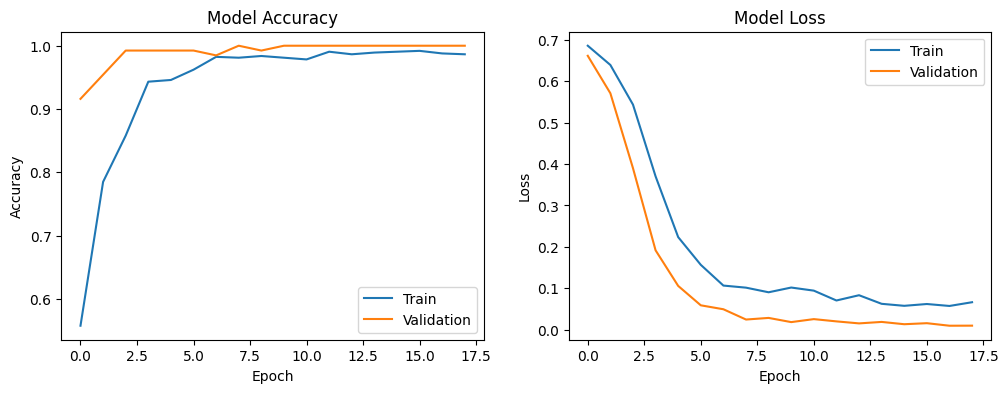

In [ ]:
# Plot the learning curves
def plot_learning_curve(history):
    plt.figure(figsize=(12, 4))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='lower right')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.show()

# Plot the learning curves
plot_learning_curve(history)

In [ ]:
# Evaluate the model using the TEST dataset
loss, accuracy = model.evaluate(X_test, y_test)

7/7 [==============================] - 0s 4ms/step - loss: 0.0650 - accuracy: 0.9906


In [ ]:
# # Plot confusion matrix
# def plot_confusion_matrix(cm, classes,
#                           normalize=False,
#                           title='Confusion matrix',
#                           cmap=plt.cm.Blues):
#     """Plots the confusion matrix."""
#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
#     tick_marks = np.arange(len(classes))
#     plt.xticks(tick_marks, classes, rotation=45)
#     plt.yticks(tick_marks, classes)

#     fmt = '.2f' if normalize else 'd'
#     thresh = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         plt.text(j, i, format(cm[i, j], fmt),
#                  horizontalalignment="center",
#                  color="white" if cm[i, j] > thresh else "black")

#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')
#     plt.tight_layout()

# # Plot non-normalized confusion matrix
# plt.figure()
# plot_confusion_matrix(cm, classes=class_names, title='Confusion Matrix of Pose Classification Model')

# # Print classification report
# print('\nClassification Report:\n', classification_report(y_test, y_pred_label, target_names=class_names))

In [ ]:
# def plot_confusion_matrix(cm, classes,
#                           normalize=False,
#                           title='Confusion matrix',
#                           cmap=plt.cm.Blues):
#   """Plots the confusion matrix."""
#   if normalize:
#     cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#     print("Normalized confusion matrix")
#   else:
#     print('Confusion matrix, without normalization')

#   plt.imshow(cm, interpolation='nearest', cmap=cmap)
#   plt.title(title)
#   plt.colorbar()
#   tick_marks = np.arange(len(classes))
#   plt.xticks(tick_marks, classes, rotation=55)
#   plt.yticks(tick_marks, classes)
#   fmt = '.2f' if normalize else 'd'
#   thresh = cm.max() / 2.
#   for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#     plt.text(j, i, format(cm[i, j], fmt),
#               horizontalalignment="center",
#               color="white" if cm[i, j] > thresh else "black")

#   plt.ylabel('True label')
#   plt.xlabel('Predicted label')
#   plt.tight_layout()

# # Classify pose in the TEST dataset using the trained model
# y_pred = model.predict(X_test)

# # Convert the prediction result to class name
# y_pred_label = [class_names[i] for i in np.argmax(y_pred, axis=1)]
# y_true_label = [class_names[i] for i in np.argmax(y_test, axis=1)]

# # Plot the confusion matrix
# cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
# plot_confusion_matrix(cm,
#                       class_names,
#                       title ='Confusion Matrix of Pose Classification Model')

# # Print the classification report
# print('\nClassification Report:\n', classification_report(y_true_label,
#                                                           y_pred_label))

#Convert the pose classification model to TensorFlow Lite

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

print('Model size: %dKB' % (len(tflite_model) / 1024))

with open('squat.tflite', 'wb') as f:
  f.write(tflite_model)

Model size: 28KB


In [ ]:
with open('squat_labels.txt', 'w') as f:
  f.write('\n'.join(class_names))

In [ ]:
# def evaluate_model(interpreter, X, y_true):
#   """Evaluates the given TFLite model and return its accuracy."""
#   input_index = interpreter.get_input_details()[0]["index"]
#   output_index = interpreter.get_output_details()[0]["index"]

#   # Run predictions on all given poses.
#   y_pred = []
#   for i in range(len(y_true)):
#     # Pre-processing: add batch dimension and convert to float32 to match with
#     # the model's input data format.
#     test_image = X[i: i + 1].astype('float32')
#     interpreter.set_tensor(input_index, test_image)

#     # Run inference.
#     interpreter.invoke()

#     # Post-processing: remove batch dimension and find the class with highest
#     # probability.
#     output = interpreter.tensor(output_index)
#     predicted_label = np.argmax(output()[0])
#     y_pred.append(predicted_label)

#   # Compare prediction results with ground truth labels to calculate accuracy.
#   y_pred = keras.utils.to_categorical(y_pred)
#   return accuracy_score(y_true, y_pred)

# # Evaluate the accuracy of the converted TFLite model
# classifier_interpreter = tf.lite.Interpreter(model_content=tflite_model)
# classifier_interpreter.allocate_tensors()
# print('Accuracy of TFLite model: %s' %
#       evaluate_model(classifier_interpreter, X_test, y_test))

Accuracy of TFLite model: 0.45754716981132076


###Install TensorFlow Lite Metadata Writer

In [ ]:
!pip install tflite-support

In [ ]:
import os
import numpy as np
from tflite_support.metadata_writers import writer_utils
from tflite_support.metadata_writers import image_classifier
from tflite_support.metadata_writers import metadata_info

In [ ]:
# Define paths for the TFLite model and the metadata output
model_path = 'squat.tflite'
model_with_metadata_path = 'squat_with_metadata.tflite'
label_file = 'squat_labels.txt'

# Create the ImageClassifierWriter
writer = image_classifier.MetadataWriter.create_for_inference(
    writer_utils.load_file(model_path),
    input_norm_mean=[127.5],
    input_norm_std=[127.5],
    label_file_paths=[label_file]
)

# Populate the metadata buffer
metadata_buf = writer.populate()

# Save the metadata to the model
# First save the original model bytes
with open(model_with_metadata_path, 'wb') as f:
    f.write(writer_utils.load_file(model_path))

# Then attach the metadata to the model
# Using writer_utils to update the model file
model_with_metadata = writer_utils.load_file(model_with_metadata_path)
with open(model_with_metadata_path, 'wb') as f:
    f.write(model_with_metadata + metadata_buf)

print("Metadata added to the model")

Metadata added to the model
